In [83]:
# Code:
# https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/acgan/acgan.py

In [2]:
# Imports
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

# Models
from torchvision.models import vgg19
from sys import path
path.append("../utils")
path.append("../")
from models import LeNet5



In [3]:
parser = argparse.ArgumentParser("ATAC-GAN MNIST")

In [55]:
# Configs

cuda = True

n_epochs=200
batch_size=64
lr=0.02
b1=0.5
b2=0.999
latent_dim=100
n_classes=10
img_size=28
channels=1
sample_interval=30

d_real_loss_coeff = 0.6
d_fake_loss_coeff = 0.4

adv_loss_coeff = 1
aux_loss_coeff = 1
tar_loss_coeff = .05

tar_loss_default = 22.2  # This is equal to the max possible tar_loss value

# target classifier conditional constants
adv_loss_threshold = 0.9
aux_loss_threshold = 1.465

lenet5_state_path = "../utils/models/trained_lenet5.pkl"


In [5]:
def load_LeNet5():
    net = LeNet5()
    if cuda:
        net.cuda()
    
    # remove map location = cpu if using cuda
    net.load_state_dict(torch.load(lenet5_state_path, map_location=torch.device('cpu')))
    
    # set model to eval mode so nothing is changed
    net.eval()
    
    return net
    

In [6]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [7]:
# Models

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(n_classes, latent_dim)

        self.init_size = img_size // 4  # Initial size before upsampling
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, noise, labels):
        gen_input = torch.mul(self.label_emb(labels), noise)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


In [65]:
from pytorch_msssim import ssim, SSIM, MS_SSIM
# reuse the gaussian kernel with SSIM & MS_SSIM. 
ssim_module = SSIM(data_range=255, size_average=True, channel=1, nonnegative_ssim=True)
ms_ssim_module = MS_SSIM(size_average=True, channel=1, nonnegative_ssim=True)


# Loss functions
target_classifier_loss = nn.CrossEntropyLoss() # negate target classifier output when passing to this loss function

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

# Load target classifier

target_classifier = load_LeNet5()

if cuda:
    generator.cuda()
    target_classifier = target_classifier.cuda()
    target_classifier_loss = target_classifier_loss.cuda()

In [9]:
# Initialize weights
generator.apply(weights_init_normal)

# Configure data loader
os.makedirs("../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

# Configure data loader
os.makedirs("../data/mnist", exist_ok=True)
ssim_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=1,
    shuffle=False,
)

In [27]:
# SSIM Metric Loss Functions
import importlib
import pytorch_ssim
importlib.reload(pytorch_ssim)
from skimage.metrics import structural_similarity as ssim


ssim_loss = pytorch_ssim.SSIM()
def ssim_to_classes(imgs):
    ret = []
    #for img in imgs:
    ss = np.zeros(10)
    counts = np.zeros(10)
    for i, (img_ref, label) in enumerate(ssim_dataloader):
        #print(img_ref.shape)
        #print(imgs.shape)
        x = pytorch_ssim.ssim(img_ref, imgs, window_size=5)
        print(x, label)
        ss[label.item()] += x
        counts[label.item()] += 1
        if i > 1000:
            break
    ret.append(np.divide(ss, counts))
    return ret
        
c = 0
ref_imgs = {}
while c < 10:
    for i, (img_ref, label) in enumerate(ssim_dataloader):
        if ref_imgs.get(label.item()) is None:
            ref_imgs[label.item()] = img_ref.cuda()
            c += 1


In [29]:
def single_ssim(label, img):
    return pytorch_ssim.ssim(ref_imgs[label.item()], img, window_size=4)
    
def batch_ssim(labels, imgs):
    ret = np.zeros(batch_size)
    for i in range(batch_size):
        ret[i] = single_ssim(labels[i], imgs[i].view(1, 1, 28, 28))
    return np.mean(ret)

imgs, l = next(iter(dataloader))
batch_ssim(l, imgs.cuda())

0.6258317376486957

In [21]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

In [67]:
def sample_image(n_row, batches_done):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, latent_dim))))
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    gen_imgs = generator(z, labels)
    save_image(gen_imgs.data, "../images/%d.png" % batches_done, nrow=n_row, normalize=True)

def get_target_loss(ssim_loss, target_classification, true_classification):
    #print(target_classification[0])
    if (ssim_loss < 0.5):
        return target_classifier_loss(target_classification * -1, true_classification)
    return Variable(FloatTensor([tar_loss_default]))
    

In [102]:
# Training
import csv
f = open('../models/RunSSIM1_log.csv', 'a')
log_writer = csv.writer(f, delimiter=',')
log_writer.writerow(['Epoch', 'SSIMLoss', 'TarLoss', 'GLoss'])
for epoch in range(40000):
    batch_size = 1
    # -----------------
    #  Train Generator
    # -----------------

    optimizer_G.zero_grad()

    # Sample noise and labels as generator input
    z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))), requires_grad=True)
    gen_labels = Variable(LongTensor(np.random.randint(0, n_classes, batch_size)))

    # Generate a batch of images
    gen_imgs = generator(z, gen_labels)

    target_classifier_pred_label = target_classifier(gen_imgs)

    t_acc = np.mean(np.argmax(target_classifier_pred_label.data.cpu().numpy(), axis=1) == gen_labels.data.cpu().numpy())

    refs = torch.zeros([batch_size, 1, 28, 28]).cuda()
    for i,l in enumerate(gen_labels):
        refs[i] = ref_imgs[l.item()][0]
    #refs = torch.from_numpy(refs).cuda()
    #ssim_loss = batch_ssim(gen_labels, gen_imgs)
    ssim_loss = 1-ssim(refs, gen_imgs, size_average=True)
    tar_loss = tar_loss_coeff * get_target_loss(ssim_loss, target_classifier_pred_label, gen_labels)
    g_loss = ssim_loss + tar_loss

    g_loss.backward()
    optimizer_G.step()

    # ---------------------
    #  Train Discriminator
    # ---------------------

    log_writer.writerow([epoch, ssim_loss.item(), tar_loss.item(), g_loss.item()])

    if epoch % sample_interval == 0:
        sample_image(n_row=10, batches_done=epoch)
        # Saves weights
        #torch.save(generator.state_dict(), "../models/SSIM1_G")
        print(
            "=====================\nEpoch %d/%d\n ssim loss: %f, tar loss: %f"
            % (epoch, n_epochs, ssim_loss.item(), tar_loss.item())
        )


Epoch 0/200
 ssim loss: 0.059007, tar loss: 0.118902
Epoch 30/200
 ssim loss: 0.066125, tar loss: 0.095602
Epoch 60/200
 ssim loss: 0.060761, tar loss: 0.118868
Epoch 90/200
 ssim loss: 0.048219, tar loss: 0.112018
Epoch 120/200
 ssim loss: 0.058537, tar loss: 0.128916
Epoch 150/200
 ssim loss: 0.066134, tar loss: 0.118855
Epoch 180/200
 ssim loss: 0.047678, tar loss: 0.113372
Epoch 210/200
 ssim loss: 0.051258, tar loss: 0.105030
Epoch 240/200
 ssim loss: 0.052911, tar loss: 0.105000
Epoch 270/200
 ssim loss: 0.051425, tar loss: 0.105033
Epoch 300/200
 ssim loss: 0.046613, tar loss: 0.113382
Epoch 330/200
 ssim loss: 0.062374, tar loss: 0.106011
Epoch 360/200
 ssim loss: 0.053357, tar loss: 0.105004
Epoch 390/200
 ssim loss: 0.063432, tar loss: 0.095595
Epoch 420/200
 ssim loss: 0.048440, tar loss: 0.113385
Epoch 450/200
 ssim loss: 0.049497, tar loss: 0.113344
Epoch 480/200
 ssim loss: 0.081319, tar loss: 0.165670
Epoch 510/200
 ssim loss: 0.058318, tar loss: 0.128923
Epoch 540/200
 

KeyboardInterrupt: 

In [12]:
# Saves weights
torch.save(generator.state_dict(), "../models/Success2_G")
torch.save(discriminator.state_dict(), "../models/Success2_D")

In [78]:
# Testing
batch_size = 1000
z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))))
gen_labels = Variable(LongTensor(np.random.randint(0, n_classes, batch_size)))

# Generate a batch of images
gen_imgs = generator(z, gen_labels)

torch.Size([1, 28, 28])


Text(0.5, 1.0, 'Gen Label: 0')

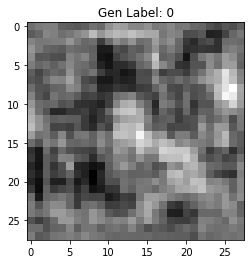

In [77]:
# Plots a sample
import matplotlib.pyplot as plt
sample_idx = 28
print(gen_imgs[sample_idx].shape)
plt.imshow(gen_imgs[sample_idx][0].cpu().detach().numpy(), cmap='gray', interpolation='none')
plt.title("Gen Label: " + str(gen_labels.cpu().detach().numpy()[sample_idx]))

torch.Size([1, 28, 28])


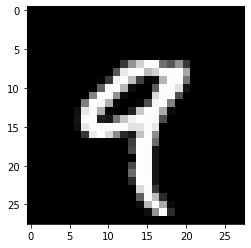

In [98]:
# Plots a ref
print(ref_imgs[0].view(1, 28, 28).shape)
plt.imshow(ref_imgs[9][0][0].cpu().detach().numpy(), cmap='gray', interpolation='none')

In [43]:
# Finds target classification for sample
pred_labels = target_classifier(gen_imgs)
np.argmax(pred_labels.data.cpu().numpy()[sample_idx])
#pred_labels.data.cpu().numpy()[sample_idx]

5

In [44]:
# Finds indexes that have adversarial examples
t_acc = np.argmax(pred_labels.data.cpu().numpy(), axis=1) == gen_labels.data.cpu().numpy()
np.where(t_acc == False)

(array([ 28, 120, 163, 301, 308, 338, 357, 381, 411, 473, 481, 630, 671,
        733, 763, 859, 939, 950, 952, 954, 961, 970]),)

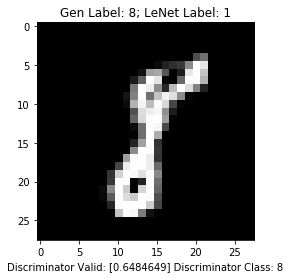

In [54]:
gen = gen_imgs.cpu().detach().numpy()
preds = pred_labels.data.cpu().numpy()
true = gen_labels.data.cpu().numpy()
v = validity.data.cpu().numpy()
dpred = dpred_labels.data.cpu().numpy()
for i in range(len(true)):
    if np.argmax(preds[i]) != true[i]:
        plt.title("Gen Label: " + str(true[i]) + "; LeNet Label: " + str(np.argmax(preds[i])))
        plt.xlabel("Discriminator Valid: " + str(v[i]) +" Discriminator Class: " + str(np.argmax(dpred[i])))
        plt.imshow(gen[i][0], cmap='gray')
        plt.savefig("../images/SecondRun/AdversarialExamples/" + str(1000+i) + ".png")
        
#for i in range(len(true)):
#    plt.title("Gen Label: " + str(true[i]) + "; LeNet Label: " + str(np.argmax(preds[i])))
#    plt.imshow(gen[i][0], cmap='gray')
#    plt.savefig("../images/SecondRun/AllSamples/" + str(i) + ".png")

In [39]:
# Extra saving
torch.save(gen_imgs, "../models/Success2_GenSample")
torch.save(gen_labels, "../models/Success2_GenLabels")
torch.save(pred_labels, "../models/Success2_LeNetLabels")

In [48]:
validity, dpred_labels = discriminator(gen_imgs)

/home/achyut/Projects/AdversarialRobustness/venv/lib/python3.8/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
